# 0.0 IMPORTS

In [98]:
import math
import pickle
import requests
import warnings
import datetime
import inflection
import pandas   as pd
import numpy    as np
import xgboost  as xgb
import seaborn  as sns
from boruta                     import BorutaPy
from scipy                      import stats  as ss
from tabulate                   import tabulate
from matplotlib                 import pyplot as plt
from IPython.display            import Image
from sklearn.ensemble           import RandomForestRegressor
from matplotlib.gridspec        import GridSpec
from sklearn.linear_model       import LinearRegression, Lasso
from sklearn.metrics            import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing      import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [2]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print(f'\nKFold Number: {k}')
    
        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )
        
        #filtering dataset
        training = x_training[ x_training['date'] < validation_start_date ]
        validation = x_training[ (x_training['date'] >= validation_start_date ) & (x_training['date'] <= validation_end_date )]
        
        #training dataset
        xtraining= training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        
        #validation datatset
        xvalidation = validation.drop( [ 'date', 'sales' ], axis=1)
        yvalidation = validation['sales']
        
        #model
        m = model.fit( xtraining, ytraining )
        
        #prediction
        yhat = m.predict( xvalidation)
        
        #performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
        
        #store performance of each kfold  iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        
    return pd.DataFrame(  {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list), 2 ).astype( str ) +  '+/-'  + np.round( np.std( mae_list), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list), 2 ).astype( str ) +  '+/-'  + np.round( np.std( mape_list), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list), 2 ).astype( str ) +  '+/-'  + np.round( np.std( rmse_list), 2 ).astype( str )}, index=[0])


def mean_percentage_error( y, yhat ):
    return np.mean( ( y-yhat )/y  )


def mean_absolute_percentage_error( y, yhat ):
    return np.mean(np.abs( ( y-yhat )/y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    
    return pd.DataFrame( { 'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE':rmse}, index=[0])

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    warnings.filterwarnings( 'ignore' )
    %matplotlib inline
    %pylab inline
    
    plt.rcParams["figure.figsize"] = (25, 20)
    plt.title("y=mx+c")
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
        
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set() 

## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False )
df_store_raw   = pd.read_csv('data/store.csv', low_memory=False )

#merge dataset

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

# 1.0 PASSO 1 - DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
#function to rename columns
snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old) )

df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print(f'Number of rows {df1.shape[0]}')
print(f'Number of columns {df1.shape[1]}')

Number of rows 1017209
Number of columns 18


## 1.3 Data Types

In [8]:
#transfomar a coluna date em formato data
df1['date'] = pd.to_datetime(df1['date'])
df1.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
#competition_distance - A estratégia é considerar a maior distancia possivel
df1['competition_distance'] =  df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month - A estratégia para as colunas de data nesse primeiro ciclo é assumir a data de registro 
#para os NA's, por ser uma coluna importante para o passo de Feature engeneering

df1['competition_open_since_month'] =  df1.apply( lambda x: x['date'].month if math.isnan( x ['competition_open_since_month'] ) 
                                                                                 else x['competition_open_since_month'], axis=1 )

#competition_open_since_year - - A estratégia é assumir a data de registro para os NA's 
df1['competition_open_since_year'] =  df1.apply( lambda x: x['date'].year if math.isnan( x ['competition_open_since_year'] ) 
                                                                                 else x['competition_open_since_year'], axis=1 )

#promo2_since_week        

df1['promo2_since_week'] =  df1.apply( lambda x: x['date'].week if math.isnan( x ['promo2_since_week'] ) 
                                                                                 else x['promo2_since_week'], axis=1 )

#promo2_since_year
df1['promo2_since_year'] =  df1.apply( lambda x: x['date'].year if math.isnan( x ['promo2_since_year'] ) 
                                                                                 else x['promo2_since_year'], axis=1 )

#Promo interval - Estratégia criar uma variavel com os meses, comparar como dataset e verificar se a loja participa ou não da promoção
#trocando o nome número pelo nome do mês 
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

#Preenchendo os NAs com 0
df1['promo_interval'].fillna(0, inplace=True)

#Extraindo mês da data e aplica o dict para fazer a tradução
df1['month_map'] = df1['date'].dt.month.map( month_map)

#Verificar se o month_map está dentro de promo_interval criar a coluna is_promo: 1 para verdadeiro e 0 falso
df1['is_promo' ] = df1[[ 'promo_interval', 'month_map' ]].apply (lambda x: 0 if x[ 'promo_interval' ] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)


## 1.6 Change Type

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [12]:
#Separa os dados em numéricos  e categóricos
num_attributes = df1.select_dtypes( include= ['int64', 'float64', 'int32'] )

cat_attributes = df1.select_dtypes( exclude= ['int64', 'float64', 'int32', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [13]:
#Central Tendence - Mean, Median

ct1 = pd.DataFrame( num_attributes.apply( np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis - complementa as informações para saber como os dados estão em relação as tendencias centrais
d1 = pd.DataFrame( num_attributes.apply( np.std) ) .T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ) .T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ) .T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate

m = pd.concat( [d2, d3, d4, ct1, ct2,d1, d5, d6 ] ).T.reset_index()

#Rename Columns
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']


In [14]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


Analisando a tabela e avaliar as variáveis
 -- Analisando a variável sales: 
     Percebe-se que o minimo é 0, ou seja não houve nenhuma venda( possivelmente porque a loja estava fechada) Max= 41551.0, 
     O range é a diferença entre o min e o max.
     A média e mediana estão bem parecidas, ou seja, o deslocamento da curva está simetrico, não há uma grande variação
     Isso é representado pela skew, pois ela está muito próxima de 0, ou seja, proxima de uma normal
     E pela kurtosis que está próxima de 1
-- Analisando a variável competition_Distance: 
      A média e mediana estão muito diferentes, ou seja,há uma grande variação nos dados e o deslocamento da curva está mais pra direita.
     Isso é representado pela skew, pois ela está muito distante de 0
     E pela kurtosis que está distante de 1
     
     Isso acontece porque há muitos competidores próximos

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

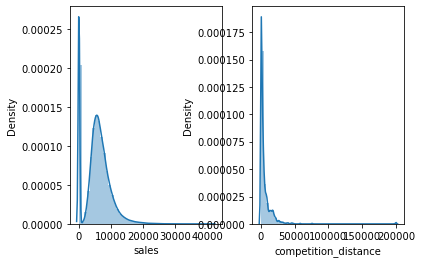

In [15]:
# Representando graficamente
plt.subplot(1, 2, 1)
plt.figsize= (25,20)
sns.distplot( df1['sales'])

plt.subplot(1, 2, 2)
sns.distplot( df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [16]:
# Niveis de variaveis categoricas
cat_attributes.apply(lambda x:x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

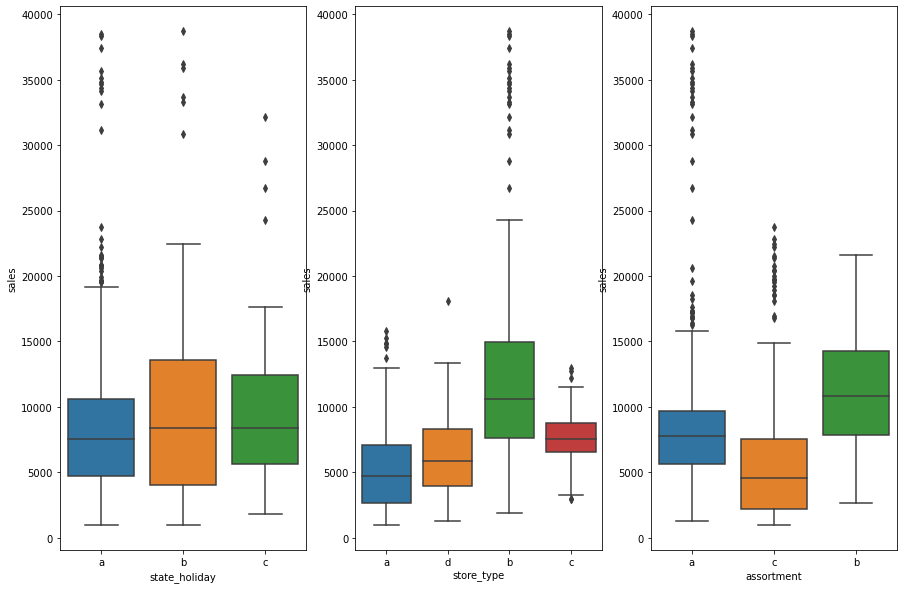

In [17]:
#Verificar as estatistica descritivas das variaveis categoricas
aux1 = df1[ ( df1['state_holiday'] != '0') & (df1['sales']> 0)] #Pegar as vendas maior que zero
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1)

Analisando os graficos:
State_ Holiday: o feriado b tem a mediana maior que a do a, mas é muito parecida como c.No feriado b há um equilibrio de vendas. Porém no c há um volume maior vendas a partir do quartil 50 ao 75.


Store_type:  a loja do tipo b tem mais outliers e a mediana de vendas é maior do que as outras lojas. Já nas outras lojas as vendas estão concentradas em torno da mediana

Assortment: a loja b tem um mix de produtos muito mais distribuido na loja b e a loja a tem mais outliers

# 2.0 PASSO 02 - FEATURE ENGINEERING


In [18]:
df2 =  df1.copy()
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


## 2.1 Mapa Mental de Hipóteses

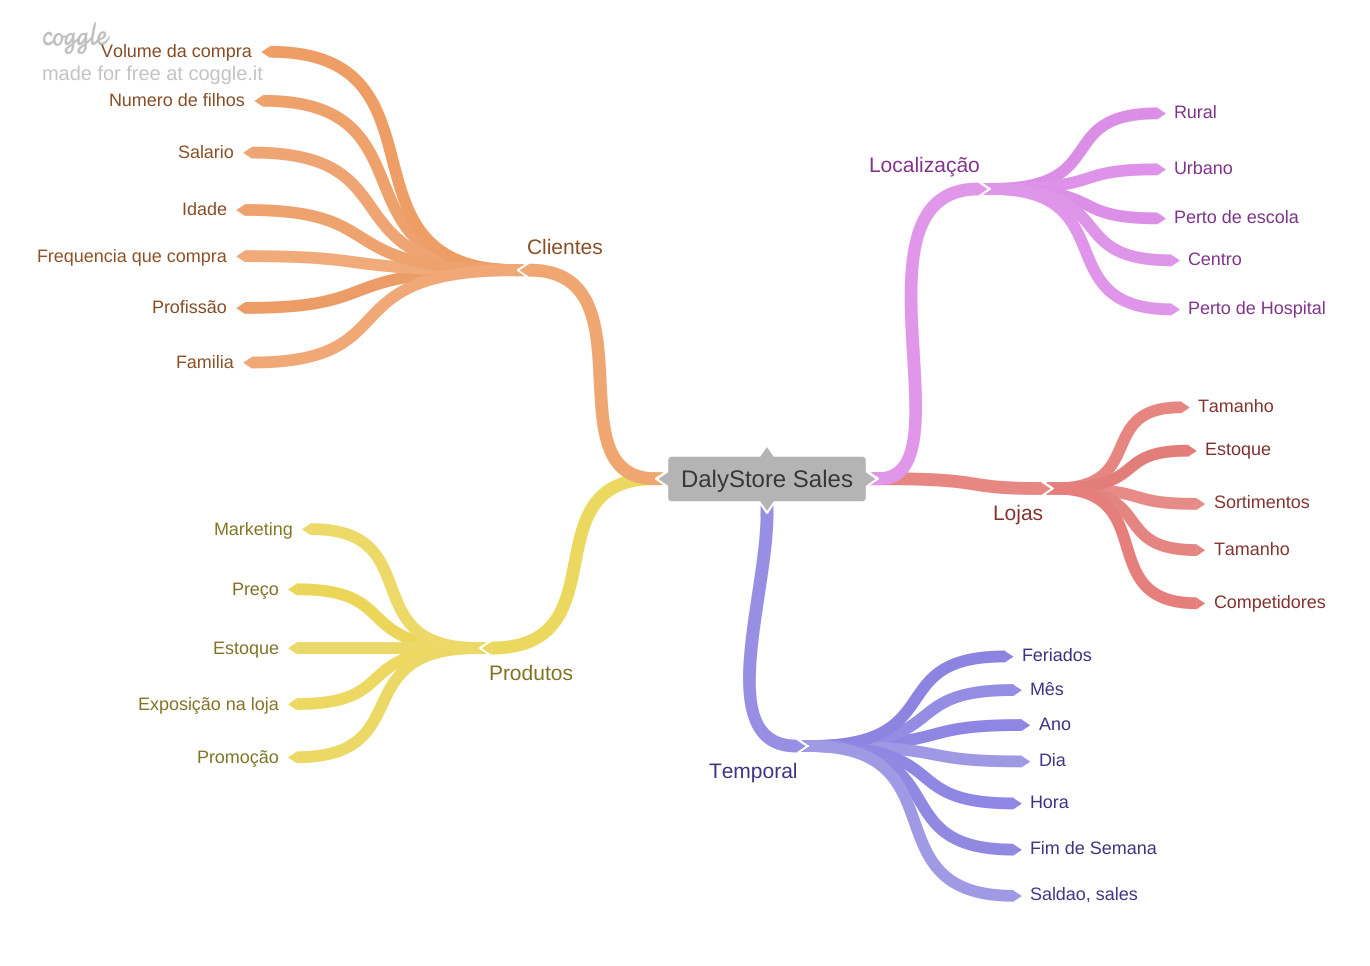

In [19]:
Image('img/mindmaphypotesis.png')

## 2.2 Criação da hipóteses

## 2.1.1 Hipoteses Loja

1. Lojas com maior quadro de funcionários deveriam vender mais.

2. Lojas com maior estoque maior deveriam vender mais

3. Lojas com maior porte deveriam vender mais

4. Lojas com menor porte deveriam vender menos

5. Lojas com maior sortimento (variedade) deveriam vender mais

6. Lojas com menor distancia entre os competidores deveriam vender menos

7. Lojas com competidores a mais tempo deveriam vender mais.

## 2.1.3 Hipoteses Produtos

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que tem uma vitrine maior deveriam vender mais.

**3.** Lojas com menores preços deveriam vender mais.

**4.** Lojas que com menores preços por mais tempo deveriam vender mais.

**5.** Lojas que com promoção deveriam vender mais.

**6.** Lojas que com mais dias de promoção deveriam vender mais.


## 2.1.2 Hipoteses Tempo

**1.** Feriados impactam negativamente nas vendas.

**2.** Lojas que atendem aos finais de semana deveriam vender mais.

**3.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**4.** Lojas deveriam vender mais ao longo dos anos.

**5.** Lojas deveriam vender mais após o dia 10.

**6.** Lojas deveriam vender menos durante feriados escolares.



## 2.2 Lista final de Hipóteses

**1.** Lojas com maior sortimento (variedade) deveriam vender mais.

**2.** Lojas com menor distancia entre os competidores deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas que com menores preços por mais tempo deveriam vender mais.

**5.** Lojas que com mais dias promoção deveriam vender mais.

**6.** Lojas que com mais dias de promoção consecutivas deveriam vender mais.

**7.** Feriados impactam negativamente nas vendas.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais após o dia 10.

**9.** Lojas deveriam vender menos durante feriados escolares.

**10.** Lojas everiam vender menos aos finais de semana.


**11.** Lojas deveriam vender mais no feriado de natal.


**12.** Lojas deveriam vender mais no segundo semestre.




## 2.3 Feature Engeneering

In [23]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [24]:
#year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# Week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
# Year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since 
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], 
                                                                  month=x['competition_open_since_month'], 
                                                                  day=1),axis=1 )
 
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

#Promo since (Variaveis que apontam quando a promoção ficou ativa)
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-'+ df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1','%Y-%W-%w' )- datetime.timedelta( days=7 ))

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7).apply( lambda x: x.days).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday

df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'Christmas' if x == 'c'else 'regular_day')


In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [26]:
df3 =df2.copy()

In [28]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [29]:
#Filtrar os dias em que as lojas estavam fechadas
df3 = df3[ ( df3['open'] != 0 ) &  (df3['sales'] > 0 )]

## 3.2 Selecao das colunas

In [30]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop( cols_drop, axis=1 )

# 4.0 PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS


In [31]:
df4 = df3.copy()

## 4.1 Análise Univariada

## 4.1.1 Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

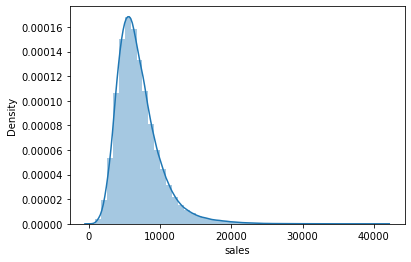

In [32]:
sns.distplot(df4['sales'])

## 4.1.2 Numerical Variable

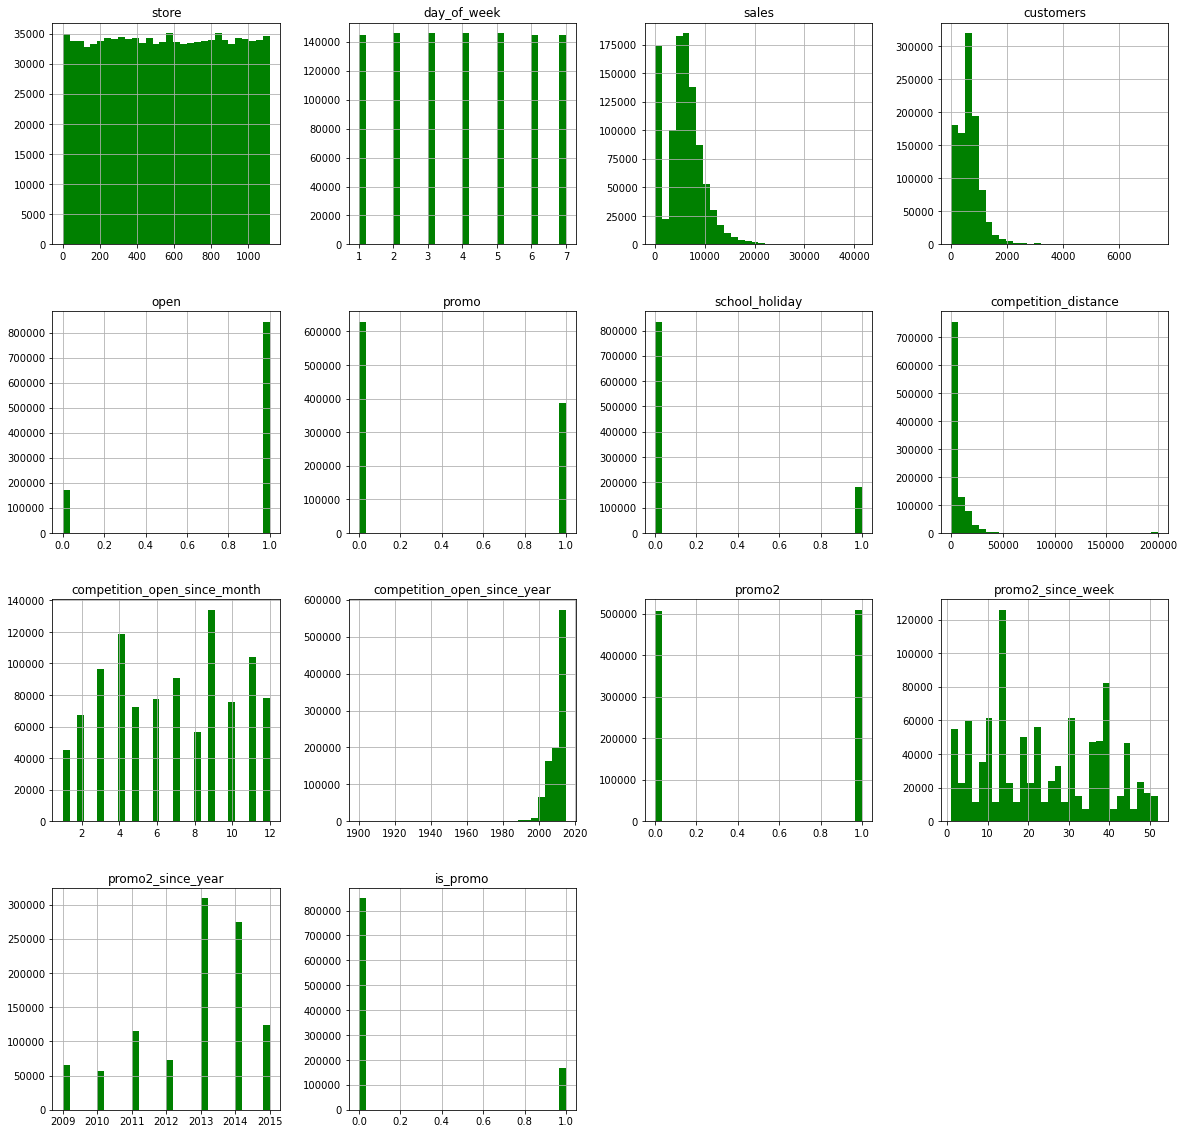

In [40]:
num_attributes.hist(bins=30,figsize= (20,20), color='g');

## 4.1.3 Categorical Variable

In [41]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public holiday
129424    easter_holiday
241126         Christmas
Name: state_holiday, dtype: object

In [42]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [43]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [44]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

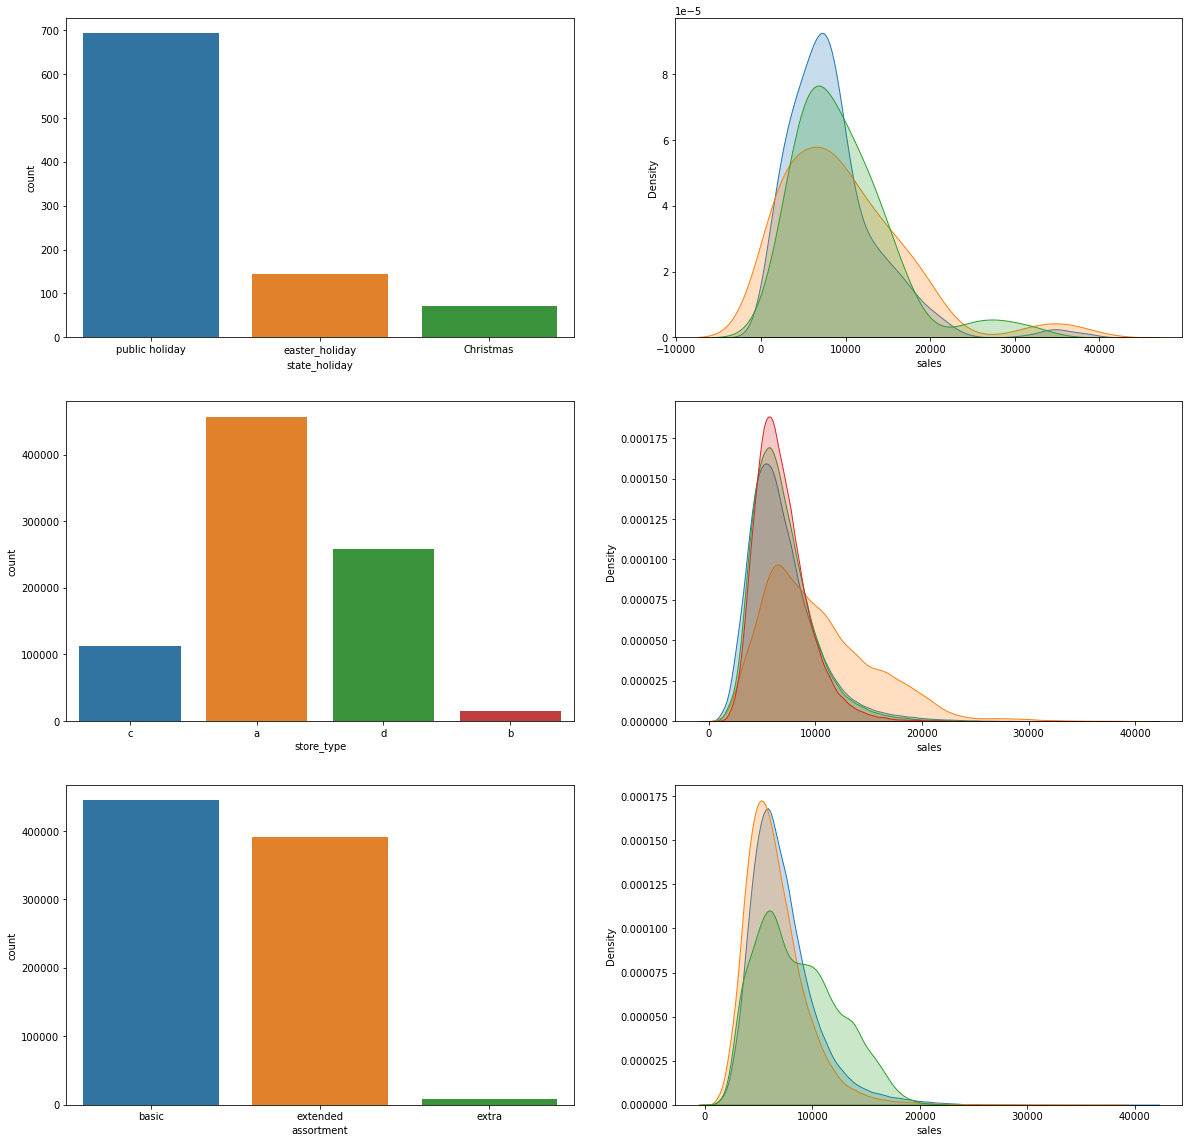

In [45]:
#state_holiday
plt.subplots(figsize = (20,20))
plt.subplot( 3, 2, 1 )
a =  df4[ df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public holiday']['sales'], label='public holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', shade=True )
#store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] ) 

plt.subplot(3, 2, 4)
sns.kdeplot( df4[df4 ['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot( df4[df4 ['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot( df4[df4 ['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot( df4[df4 ['store_type'] == 'd']['sales'], label = 'd', shade = True)

#Assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] ) 

plt.subplot(3, 2, 6)
sns.kdeplot( df4[df4 ['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot( df4[df4 ['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot( df4[df4 ['assortment'] == 'extra']['sales'], label = 'extra', shade = True);



## 4.2 Análise Bivariada

## **H.1** Lojas com maior sortimento(variedade) deveriam vender mais

***Falsa*** Lojas com MAIOR ASSORTMENT vende MENOS

<AxesSubplot:xlabel='year_week'>

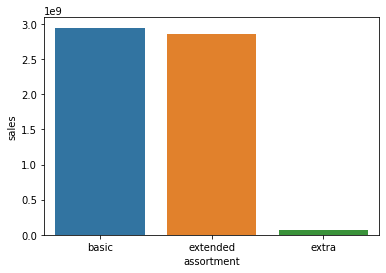

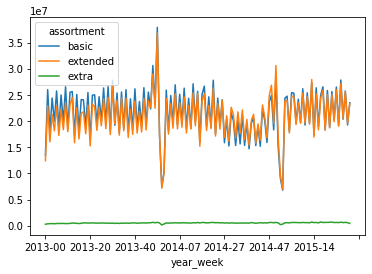

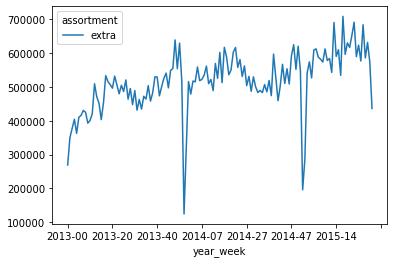

In [46]:

aux1 = df4[ ['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

#Verificar o movimento do asortmente extra
aux2 = df4[ [ 'year_week', 'assortment', 'sales'] ].groupby( ['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index = 'year_week', columns='assortment', values='sales').plot()

aux3 = aux2[ aux2['assortment'] == 'extra']
aux3.pivot( index = 'year_week', columns='assortment', values='sales').plot()

## **H.2** Lojas com maior competidores mais próximos vendem menos
**Falsa** é uma hipótese falsa porque lojas com competidores próximos vendem mais

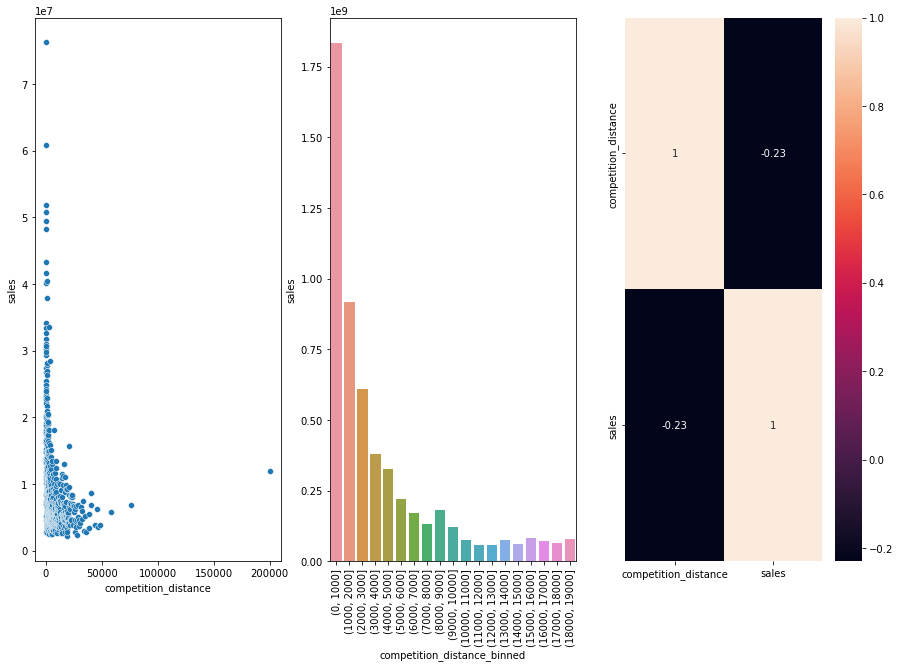

In [47]:
aux1 = df4[ ['competition_distance', 'sales'] ].groupby( 'competition_distance' ).sum().reset_index()

plt.subplots(figsize = (15,10))
plt.subplot( 1, 3, 1 )
sns.scatterplot (x='competition_distance', y='sales', data=aux1)


plt.subplot( 1, 3, 2 )
bins = list(np.arange( 0, 20000, 1000 ))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

#Gráfico de correlação
plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr( method='pearson' ), annot=True);


## **H.3** Lojas com competidores a mais tempo deveriam vender mais
**False** Hipótese falsa porque loja com competidores a mais tempo vendem menos

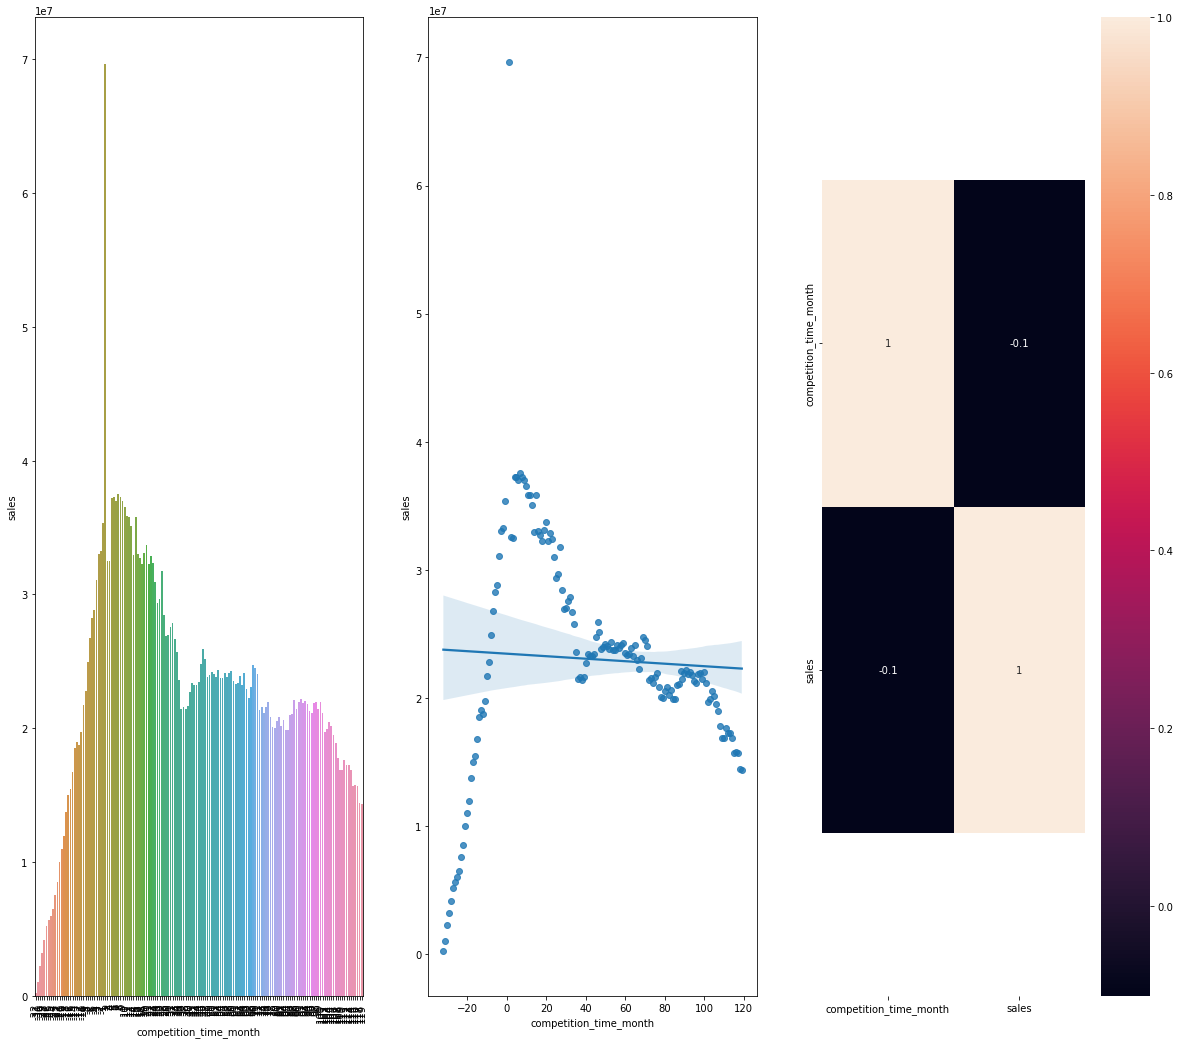

In [48]:
plt.subplots(figsize = (20,18))
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

## **H.4** Lojas com promoção ativa por mais tempo deveriam vender mais.
**False** Porque lojas com promoção ativa por mais tempo, após certo período tende diminuir as vendas

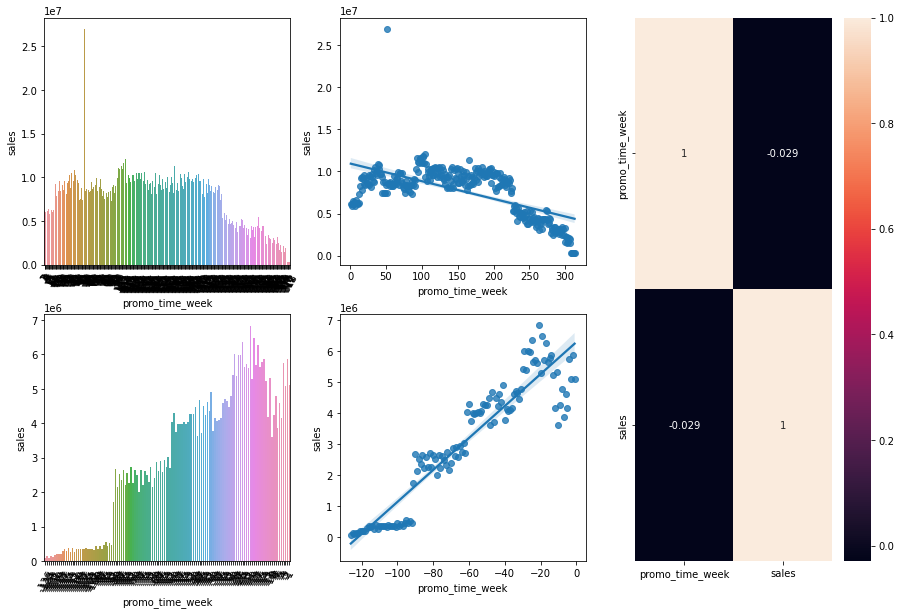

In [49]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
grid = GridSpec(2, 3)

#Visualizar por partes para melhor análise dos dados periodo normal/periodo estendido
plt.subplots(figsize = (15,10))
plt.subplot(grid[ 0, 0 ])
aux2 = aux1 [aux1['promo_time_week'] > 0 ] #promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks( rotation=60);

plt.subplot(grid [0 , 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[ 1,0 ] )
aux3 = aux1 [aux1['promo_time_week'] < 0 ] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks( rotation=60);


plt.subplot(grid[ 1, 1 ])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

#Encontrar a correlação
plt.subplot(grid[ :,2])
sns.heatmap(aux1.corr( method='pearson'), annot=True);

## <s>**H.5**  Lojas com mais dias de promoção deveriam vender mais.<s>


## **H.6** Lojas com mais promoções consecutivas deveriam vender mais
 **Falsa** Lojas com mais promoções consecutivas vendem menos

In [50]:
#Verificar se o resultado de vendas mudou a partir da efetivação da promoção
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


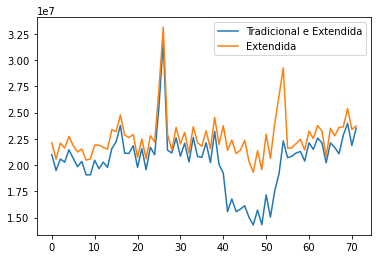

In [51]:
aux1 = df4[( df4['promo'] == 1) & ( df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax= aux1.plot()

aux2 = df4[( df4['promo'] == 1) & ( df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend( labels=['Tradicional e Extendida', 'Extendida']);

## **H.11** Lojas deveriam vender mais no feriado de natal.
**Falsa** No Natal as lojas vendem menos

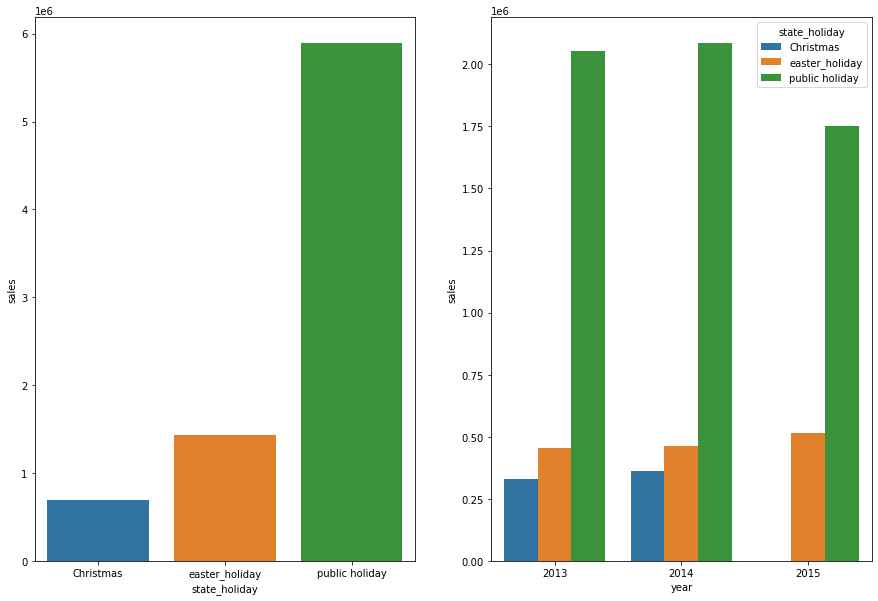

In [52]:
# Remover regular day para analisar apenas feriados
aux = df4[ df4['state_holiday'] != 'regular_day']
plt.subplots(figsize = (15,10))
plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales',hue='state_holiday', data=aux2);


## **H.8** - Lojas deveriam vender mais ao longo dos anos.
**Falsa** - Lojas vendem menos ao longo dos anos



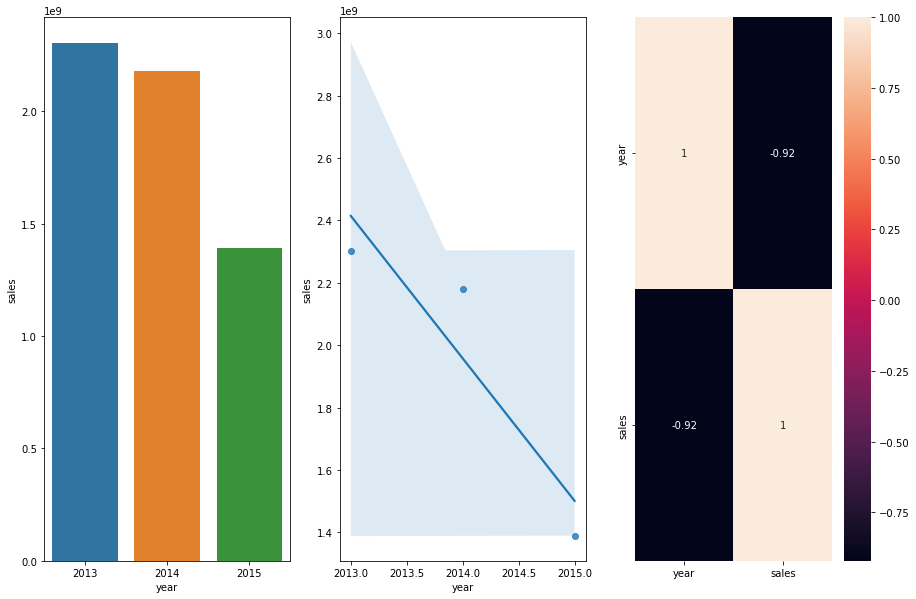

In [53]:
plt.subplots(figsize = (15,10))
plt.subplot(1, 3, 1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1);


#Verificar as tendencias
plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr( method='pearson'),annot=True); 

## **H.9** - Lojas deveriam vender mais no segundo semestre.
**Falsa** - Lojas vendem menos no segundo semestre

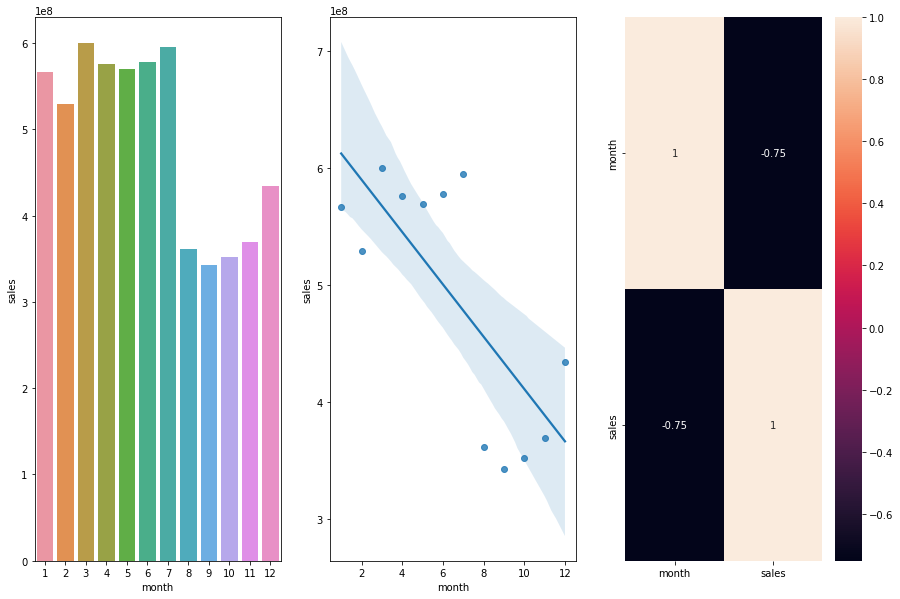

In [54]:
plt.subplots(figsize = (15,10))
plt.subplot(1, 3, 1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1);


#Verificar as tendencias
plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr( method='pearson'),annot=True); 

4. Lojas que com menores preços por mais tempo deveriam vender mais.

6. Lojas que com mais dias de promoção consecutivas deveriam vender mais.

7. Feriados impactam negativamente nas vendas.

8. Lojas deveriam vender mais ao longo dos anos.

9. Lojas deveriam vender mais após o dia 10.

9. Lojas deveriam vender menos durante feriados escolares.

10. Lojas everiam vender menos aos finais de semana.

11. Lojas deveriam vender mais no feriado de natal.

12. Lojas deveriam vender mais no segundo semestre.

   ### 4.2.1. Resumo das Hipoteses

In [55]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1. Numerical Attributes

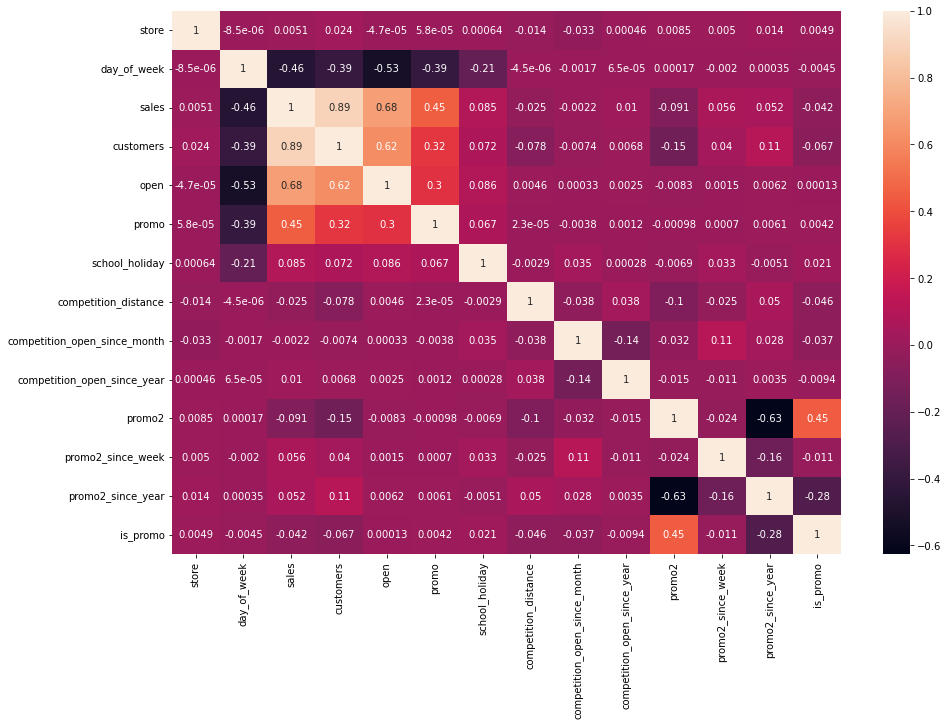

In [56]:
correlation = num_attributes.corr( method='pearson' )
plt.subplots(figsize = (15,10))
sns.heatmap( correlation, annot=True );

In [58]:
#correlação dos atributos com as vendas
correlations = num_attributes.corr()['sales'].sort_values()
correlations

day_of_week                    -0.462125
promo2                         -0.091040
is_promo                       -0.042084
competition_distance           -0.024747
competition_open_since_month   -0.002198
store                           0.005126
competition_open_since_year     0.010006
promo2_since_year               0.052108
promo2_since_week               0.055889
school_holiday                  0.085124
promo                           0.452345
open                            0.678472
customers                       0.894711
sales                           1.000000
Name: sales, dtype: float64

### 4.3.2. Categorical Attributes

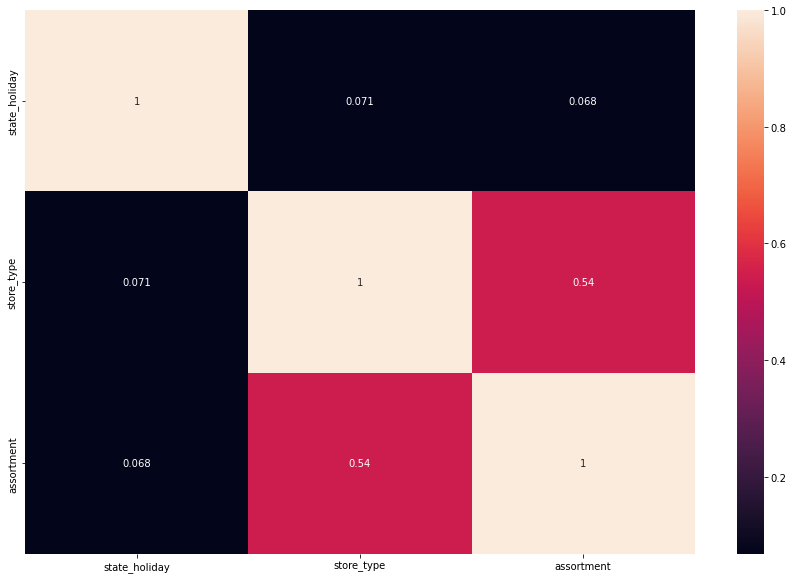

In [59]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

plt.subplots(figsize = (15,10))
sns.heatmap( d, annot=True );

# 5.0 PASSO 05 - DATA PREPARATION

In [60]:
df5 = df4.copy()

## 5.1 Normalização
**Não é necessário fazer a normalização**

## 5.2 Rescaling

In [61]:
#Variaveis selecionada para aplicar Robustscaller

rs = RobustScaler()
mns = MinMaxScaler()
#competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)

pickle.dump(rs, open( 'parameter/competition_distance_scaler.pkl', 'wb'))

#competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)
pickle.dump(rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb'))

#promo time week
df5['promo_time_week'] = mns.fit_transform( df5[['promo_time_week']].values)
pickle.dump(rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb'))

#year
df5['year'] = mns.fit_transform( df5[['year']].values)
pickle.dump(rs, open( 'parameter/year_scaler.pkl', 'wb'))

## 5.3 Transformação

### 5.3.1 Encoding

In [62]:
#state_holiday - One hot Encoding
df5 = pd.get_dummies( df5, prefix =['state_holiday'], columns=['state_holiday'] ) 

#store_type -Label encoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5 ['store_type']) 
pickle.dump(le, open( 'parameter/store_type_scaler.pkl', 'wb'))
#assortment (encoding do tipo ordinal)
assortment_dict ={'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map( assortment_dict)


### 5.3.2 Response Variable Transformation

In [63]:
df5['sales'] = np.log1p( df5['sales'] )

<AxesSubplot:xlabel='sales', ylabel='Density'>

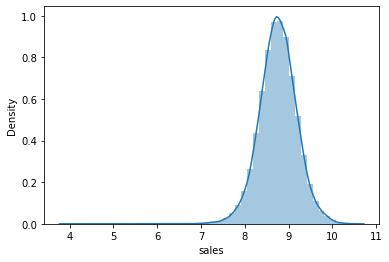

In [64]:
sns.distplot( df5['sales'] )

### 5.3.3 Nature Transformation


In [65]:
#Variaveis de natureza cíclica
#Day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7 ) ) )    

#month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )
    
    #day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30 ) ) )
    
    #week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52) ) )    
    

In [66]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0 PASSO 6 - FEATURE SELECTION

In [67]:
df6 = df5.copy()

In [68]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## 6.1 Split dataframe into training and test dataset

In [105]:
#Excluir variaveis
cols_drop = ['week_of_year', 'day','month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1) 

In [69]:
#Selecionando a data: pegar as últimas 6 semanas de vendas para teste e o restante para treino
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days=6*7)

Timestamp('2015-06-19 00:00:00')

In [70]:
#training dataset
X_train = df6[ df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[ df6['date'] >= '2015-06-19']
y_test = X_test['sales']


print('Training Min Date {}'.format(X_train['date'].min() ) )
print('Training Max Date {}'.format(X_train['date'].max() ) )


print('\nTest Min Date {}'.format(X_test['date'].min() ) )
print('Test Max Date {}'.format(X_test['date'].max() ) )


Training Min Date 2013-01-01 00:00:00
Training Max Date 2015-06-18 00:00:00

Test Min Date 2015-06-19 00:00:00
Test Max Date 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [71]:
##Training and test for boruta
#x_train_n = X_train.drop( ['date', 'sales'], axis=1). values
#y_train_n = y_train.values.ravel()
#
##define Random Forest Regressor
#rf = RandomForestRegressor( n_jobs=-1)
#
###define boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

### 6.2.1 Best Features from  Boruta

In [72]:
##Selecionar as variaveis que o boruta ranqueou
#cols_selected = boruta.support_.tolist()
#
##coluna por nome
#x_train_fs = X_train.drop( [ 'date', 'sales'], axis=1)
#cols_selected_boruta =  x_train_fs.iloc[:, cols_selected].columns.to_list()
#
###comparar as colunas selecionadas com as colunas não selecionadas
#cols_not_selected_boruta = list( np.setdiff1d(x_train_fs.columns, cols_selected_boruta) )

In [73]:
#cols_selected_boruta

## 6.3 Manual Feature Selection

In [74]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

#columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )


In [75]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# 7.0 PASSO 07 - MACHINE LEARNING MODELLING

In [76]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

#Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full]

## 7.1 Average Model

In [141]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales':'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

#Performance
baseline_result = ml_error('Average Model', np.expm1( y_test ), np.expm1( yhat_baseline) )

baseline_result



,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [142]:
#model

lr = LinearRegression().fit( x_train, y_train)

#predicition
yhat_lr = lr.predict( x_test )

#performance
lr_result = ml_error('Linear regression', np.expm1(y_test), np.expm1( yhat_lr) )

lr_result 


,Model Name,MAE,MAPE,RMSE
0,Linear regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear regression Model - Cross Validation

In [143]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv   

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [144]:
#model
lrr = Lasso( alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict( x_test )

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1( y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1  Lasso - Cross Validation

In [145]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


## 7.4 Random Forest Regressor

In [146]:
#model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict( x_test )

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1( y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1 Random Forest Regressor - Cross Validation

In [147]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61+/-217.1,0.12+/-0.02,1254.3+/-316.17


## 7.5 XGboost Regressor

In [150]:
#model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
                              n_estimators=100, 
                              eta=0.09, 
                              max_depth=10,
                              subsample=0.5,
                              colsample_bytree=1).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict( x_test )

#performance
xgb_result = ml_error('XGBoost Regressor',np.expm1( y_test), np.expm1(yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,855.127215,0.124085,1258.2226


### 7.5.1 XGboost Regressor - Cross Validation

In [151]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1024.35+/-168.97,0.14+/-0.02,1470.6+/-221.9


## 7.6 Compare Model's Performance

In [152]:
x_training = X_train[ cols_selected_boruta]

### 7.6.1 Single Performance

In [153]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values('RMSE')


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,XGBoost Regressor,855.127215,0.124085,1258.222600
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2 Real Performance - Cross Validation

In [154]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26
0,Random Forest Regressor,836.61+/-217.1,0.12+/-0.02,1254.3+/-316.17
0,XGBoost Regressor,1024.35+/-168.97,0.14+/-0.02,1470.6+/-221.9


# 8.0 PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [ ]:
#param = {
#        'n_estimators': [ 1500, 1700, 2500, 3000, 3500 ],
#        'eta': [ 0.01, 0.03 ],
#        'max_depth': [ 3, 5, 9 ],
#        'subsample': [0.1, 0.5, 0.7 ],
#        'colsample_bytree': [ 0.3, 0.7, 0.9],
#        'min_child_weight': [ 3, 8, 15 ]}
#MAX_EVAL = 10

In [ ]:
#final_result = pd.DataFrame()
#
#for i in range (MAX_EVAL):
#    #choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
##model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#   
#    #performance
#    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )
#    final_result = pd.concat( [final_result, result] )
#
#final_result

## 8.2 Final Model 

In [78]:
param_tuned = {
        'n_estimators':1500,
        'eta':0.03 ,
        'max_depth':9,
        'subsample': 0.5,
        'colsample_bytree':0.9,
        'min_child_weight':8 }


In [79]:
#model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror', 
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit(x_train, y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test) , np.expm1(yhat_xgb_tuned) )
xgb_result_tuned 

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,634.758836,0.09154,923.453008


In [80]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )

In [81]:
mpe

0.012678662253052315

In [82]:
pickle.dump( model_xgb_tuned, open('model/model_rossmann.pkl', 'wb'))

# 9.0 PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO

In [83]:
#copiar o dataframe com as colunas seleconadas pelo boruta
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1( df9[ 'sales' ])
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1 Business Performance

In [84]:
 # somar as predições
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE

df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions']) ).reset_index( ).rename( columns={0: 'MAE'})


df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions']) ).reset_index( ).rename( columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')

df92 = pd.merge(df91, df9_aux3, how='inner', on='store')


#Cenarios

df92['worst_scenario'] = df92['predictions'] - df92['MAE']

df92['best_scenario'] = df92['predictions'] + df92['MAE']

#Ordenar colunas

df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [85]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
825,826,327463.593750,326719.682208,328207.505292,743.911542,0.088555
152,153,254300.796875,253369.898569,255231.695181,930.898306,0.154752
553,554,190795.078125,190191.124010,191399.032240,603.954115,0.106654
566,567,190395.671875,189903.298175,190888.045575,492.373700,0.103215
247,248,289675.562500,289054.509343,290296.615657,621.053157,0.079839


In [86]:
df92.sort_values( 'MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105884.257812,102611.412508,109157.103117,3272.845305,0.549219
908,909,245512.937500,238013.256645,253012.618355,7499.680855,0.518098
875,876,195875.718750,192048.268778,199703.168722,3827.449972,0.272395
549,550,241629.046875,240297.261930,242960.831820,1331.784945,0.255581
273,274,196997.968750,195668.885913,198327.051587,1329.082837,0.229522


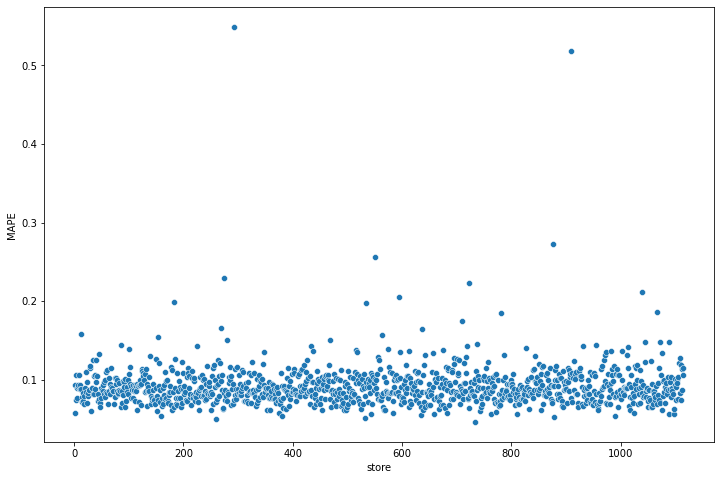

In [87]:
plt.subplots(figsize = (12,8))
sns.scatterplot(x='store', y='MAPE', data=df92);

## 9.2 Total Performance

In [88]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns ={'index':'scenario', 0:'values'})
df93['values'] = df93['values'].map('R$ {:,.2f}'.format )
df93

,scenario,values
0,predictions,"R$ 282,044,480.00"
1,worst_scenario,"R$ 281,332,649.73"
2,best_scenario,"R$ 282,756,308.87"


## 9.3 Machine Learning Performance

In [89]:
df9['error'] = df9['sales'] - df9['predictions']

df9['error_rate'] = df9['predictions'] / df9['sales']


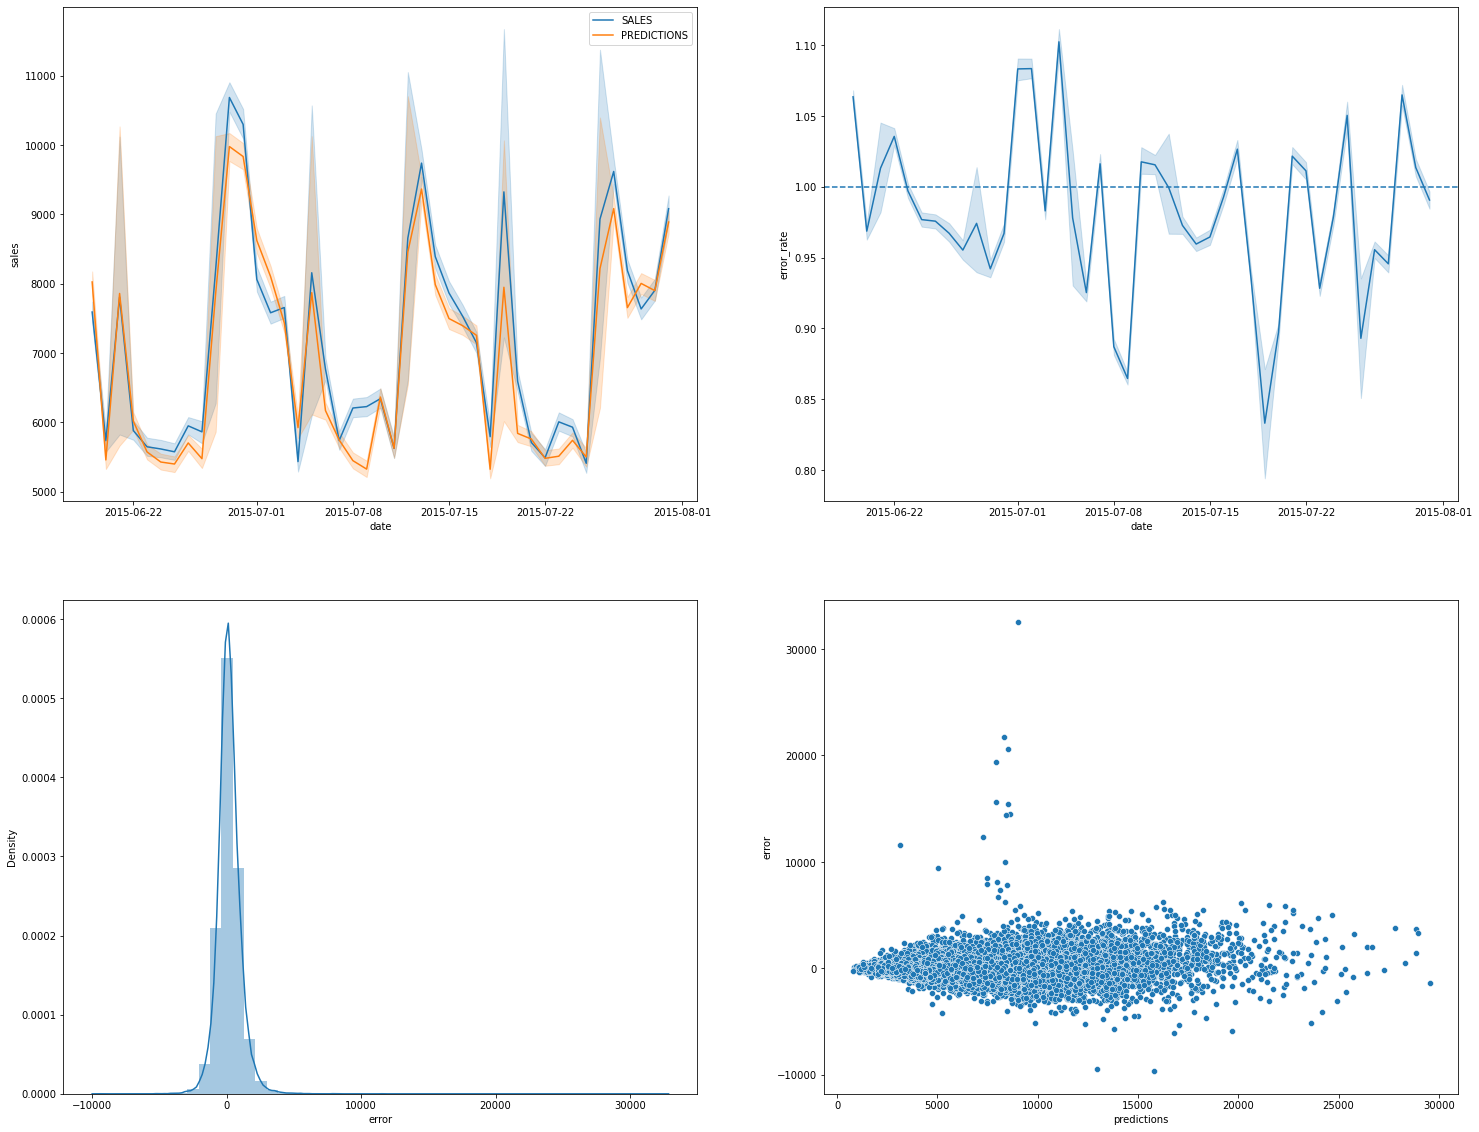

In [91]:
#Gráficos

plt.subplot(2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS')


plt.subplot(2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot(2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot(2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )
#plt.rcParams["figure.figsize"] = (25,20)
#plt.title("y=mx+c")
#plt.xlabel('x-axis')
#plt.ylabel('y-axis')

plt.show()

# 10. PASSO 10 - DELOY MODEL TO PRODUCTION

In [92]:

#pickle.dump( model_xgb_tuned, open('model_rossmann.pkl', 'wb'))

## 10.1 Rossmann Class

In [93]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__(self):
        self.home_path='C:/Users/PC/SejaUmDataScientist/rossmann_predict_sales/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path +'parameter/competition_distance_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load( open( self.home_path +'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load( open( self.home_path +'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load( open( self.home_path +'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load( open( self.home_path +'parameter/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning( self, df1 ):
        

       ## 1.1 Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list( map( snakecase, cols_old) )

        df1.columns = cols_new

        ## 1.3 Data Types

        #mudar formato data
        df1['date'] = pd.to_datetime( df1[ 'date' ] )

        ## 1.5 Fillout NA
        #competition_distance 
        df1['competition_distance'] =  df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month 
        df1['competition_open_since_month'] =  df1.apply( lambda x: x['date'].month if math.isnan( x ['competition_open_since_month'] ) 
                                                                                         else x['competition_open_since_month'], axis=1 )
        #competition_open_since_year  
        df1['competition_open_since_year'] =  df1.apply( lambda x: x['date'].year if math.isnan( x ['competition_open_since_year'] ) 
                                                                                         else x['competition_open_since_year'], axis=1 )
        #promo2_since_week        
        df1['promo2_since_week'] =  df1.apply( lambda x: x['date'].week if math.isnan( x ['promo2_since_week'] ) 
                                                                                         else x['promo2_since_week'], axis=1 )
        #promo2_since_year
        df1['promo2_since_year'] =  df1.apply( lambda x: x['date'].year if math.isnan( x ['promo2_since_year'] ) 
                                                                                        else x['promo2_since_year'], axis=1 )
        #trocando o nome número pelo nome do mês
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        #Preenchendo os NAs com 0
        df1['promo_interval'].fillna(0, inplace=True)

        #Extraindo mês da data
        df1['month_map'] = df1['date'].dt.month.map( month_map)


        df1['is_promo' ] = df1[[ 'promo_interval', 'month_map' ]].apply (lambda x: 0 if x[ 'promo_interval' ] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)


        ## 1.6 Change Type

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1

    def feature_engineering( self, df2 ):
        #year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # Week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week         #weekofyear
        # Year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

         # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2
    
    def data_preparation(self, df5):
        
        ## 5.2 Rescaling
        
        #competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values)
        


        #competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values)
       

        #promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values)
        
        #year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values)
        
        ## 5.3 Transformação

        ### 5.3.1 Encoding

        #state_holiday - One hot Encoding
        df5 = pd.get_dummies( df5, prefix =['state_holiday'], columns=['state_holiday'] ) 

        #store_type -Label encoder

        df5['store_type'] = self.store_type_scaler.fit_transform(df5 ['store_type']) 

        #assortment (encoding do tipo ordinal)
        assortment_dict ={'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map( assortment_dict)


        ### 5.3.3 Nature Transformation
        #Day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7 ) ) )    

        #month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

            #day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30 ) ) )

            #week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52) ) )
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',  'competition_open_since_month',
                         'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                         'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin',
                         'day_cos', 'week_of_year_sin','week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction( self, model, original_data, test_data ):
        #prediction
        pred = model.predict( test_data )
        
        #join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso')

## 10.2 API Handler

In [183]:
import pickle
import requests
import pandas as pd
from flask              import Flask, request, Response
from rossmann.Rossmann  import Rossmann

# Loading model
model = pickle.load( open( 'C:/Users/PC/SejaUmDataScientist/DS_Producao/model/model_rossmann.pkl', "rb"))

# inicialize API
app = Flask( __name__ )
 
@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )
    

## 10.3 API tester

In [94]:
# loading test dataset
df10 = pd.read_csv('C:/Users/PC/SejaUmDataScientist/rossmann_predict_sales/Data/test.csv' )

In [102]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

#choose store for prediction

df_test = df_test[ df_test['Store'].isin( [11, 15, 24] )]

#remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test =df_test.drop( 'Id', axis=1 )

In [103]:
#convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records') )

In [104]:
# API call
#url ='http://192.168.15.38:5000/rossmann/predict'
url = 'https://mas-rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data= data

r = requests.post( url, data=data, headers=header)
print( 'Status Code{}'.format(r.status_code) )

Status Code200


In [105]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [106]:
d2 = d1[[ 'store', 'prediction']].groupby('store').sum().reset_index()

for i in range( len( d2 ) ):
    print('Store number {} will sell R$ {:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction']))

Store number 11 will sell R$ 177,837.10 in the next 6 weeks
Store number 15 will sell R$ 299,795.78 in the next 6 weeks
Store number 24 will sell R$ 246,143.37 in the next 6 weeks
